In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings("ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./casia-train-model.ipynb
./s41598-021-96872-w.pdf
./remotesensing-13-02468.pdf
./README.md
./prise_en_main/open-y-and-baselines.ipynb
./prise_en_main/compute-baseline-obs.ipynb
./prise_en_main/open-x-forecast-3d-train.ipynb
./prise_en_main/open-x-station.ipynb
./prise_en_main/open-x-forecast-2d-train.ipynb
./prise_en_main/open-mask-data.ipynb
./prise_en_main/open-x-forecast-3d-test.ipynb
./prise_en_main/open-x-forecast-2d-test.ipynb
./data/.gitignore
./data/df_tot.csv
./data/Other/Other/stations_coordinates.csv
./data/Other/Other/NW_masks.nc
./data/Test/Test/Id_month_test.csv
./data/Test/Test/X_station_test.csv
./data/Test/Test/X_forecast/2D_arpege_119.nc
./data/Test/Test/X_forecast/arpege_3D_isobar_118.nc
./data/Test/Test/X_forecast/2D_arome_119.nc
./data/Test/Test/X_forecast/arpege_3D_height_119.nc
./data/Test/Test/Baselines/Baseline_forecast_test.csv
./data/Test/Test/Baselines/Baseline_observation_test.csv
./data/Train/Train/Y_train.csv
./data/Train/Train/X_station_train.csv
./data

./.git/refs/heads/main
./.git/refs/remotes/origin/HEAD
./.git/refs/remotes/origin/main
./.git/logs/HEAD
./.git/logs/refs/heads/main
./.git/logs/refs/remotes/origin/HEAD
./.git/logs/refs/remotes/origin/main
./.git/info/exclude


In [2]:
### Fonctions utiles :
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

### load X_train

In [3]:
first_date = datetime.datetime(2016,1,1)    
last_date = datetime.datetime(2017,12,31)
coords_fname  = './data/Other/Other/stations_coordinates.csv'
fname = './data/Train/Train/X_station_train.csv'

In [4]:
# imputer = KNNImputer(n_neighbors=1)
# imputer.fit(df_imput)
# df_imput = train[["ff","t","td","hu","dd","precip"]].copy()
# X = imputer.transform(df_imput)
# print("Je commence l'imputation")
# df_imput= pd.DataFrame(X,columns = df_imput.columns)
# train[["ff","t","td","hu","dd","precip"]] = df_imput[["ff","t","td","hu","dd","precip"]]
# # reorganisation des données.
# print("Fin de l'imputation")

In [18]:
# Cette fonction ne prend en compte que les données présentes dans Xstation
def load_X_train(fname,coords_fname) :
    to_shift = ['ff_mean', 'ff_min', 'ff_max', 'ff_std',
       'ff_median', 'ff_sum', 'ff_count', 'ff_percentile_10',
       'ff_percentile_25', 'ff_percentile_80', 'ff_percentile_95', 't_mean',
       't_min', 't_max', 't_std', 't_median', 't_sum', 't_count',
       't_percentile_10', 't_percentile_25', 't_percentile_80',
       't_percentile_95', 'td_mean', 'td_min', 'td_max', 'td_std', 'td_median',
       'td_sum', 'td_count', 'td_percentile_10', 'td_percentile_25',
       'td_percentile_80', 'td_percentile_95', 'hu_mean', 'hu_min', 'hu_max',
       'hu_std', 'hu_median', 'hu_sum', 'hu_count', 'hu_percentile_10',
       'hu_percentile_25', 'hu_percentile_80', 'hu_percentile_95', 'dd_mean',
       'dd_min', 'dd_max', 'dd_std', 'dd_median', 'dd_sum', 'dd_count',
       'dd_percentile_10', 'dd_percentile_25', 'dd_percentile_80',
       'dd_percentile_95', 'precip_sum']
    coords = pd.read_csv(coords_fname)
    train = pd.read_csv(fname,parse_dates=['date'],infer_datetime_format=True)
    train['number_sta']=train['number_sta'].astype('category')
    #sort by station, then by date 
    train = train.sort_values(['number_sta','date'])   
    method_traitements = ["mean","min","max","std","median","sum","count",percentile(10),percentile(25),percentile(80),percentile(95)]
    dict_to_split = {"ff":method_traitements,"t":method_traitements,"td":method_traitements
                     ,"hu":method_traitements,"dd":method_traitements,"precip":"sum"}
    Base_obs = train[{"number_sta","date","ff","t","td","hu","dd","precip"}].copy()
    Base_obs.set_index('date',inplace = True)  

    # type de traitement.
    Base_obs_type = Base_obs.groupby('number_sta').resample('D').agg(dict_to_split)
    Base_obs_type.columns = ['_'.join(col).strip() for col in Base_obs_type.columns.values]
    Base_obs_type = Base_obs_type.reset_index(['date','number_sta']) 
    Base_obs_type['number_sta'] = Base_obs_type['number_sta'].astype('category')   
    #Select the observations the day before
    Base_obs_type[to_shift] = Base_obs_type.groupby(['number_sta'])[to_shift].shift(1)    
    Base_obs_type = Base_obs_type.sort_values(by=["number_sta","date"])
    #del Base_obs['precip']
    Base_obs_type.rename(columns={'precip_sum':'Prediction'},inplace=True)
    #del Base_obs_type["precip_sum"]
    date = first_date
    dates = []
    while date <= (last_date - datetime.timedelta(days=1)):
        date += datetime.timedelta(days=1)
        dates.append(date)

    d_dates =  pd.DataFrame(dates, columns = ['date'])
    d_dates['day_index'] = d_dates.index
    y_f = Base_obs_type.merge(d_dates,how="right",on = ["date"])
    y_f = y_f[y_f['date']!=last_date]
    y_f['Id'] = y_f[list(y_f.columns)[0]].astype(str) + '_' + \
                      y_f['day_index'].astype(str) 
    #y_f["number_sta"] = y_f[("number_sta","")]
    y_f = y_f.merge(coords,on=["number_sta"],how="right")
    X_train = y_f.copy()#drop(["day_index"],axis=1)
    X_train["month"] = X_train["date"].dt.month
    X_train["day"] = X_train["date"].dt.day
    X_train.drop(["date"],axis=1,inplace=True)
    return X_train

In [19]:
train = load_X_train(fname,coords_fname)

In [20]:
train_forecast = pd.read_csv("./data/Train/Train/Baselines/Baseline_forecast_train.csv")

In [21]:
train_forecast.rename(columns={"Prediction":"Forecasted"},inplace = True)
train_forecast.drop(["date","number_sta"],axis = 1 ,inplace = True)

In [22]:
value_list = list(train["Id"])
boolean_series = train_forecast.Id.isin(value_list)
train_forecast = train_forecast[boolean_series]

In [23]:
train = train.merge(train_forecast,on=["Id"],how="right")

### Load Y_test

In [13]:
fname_test = "./data/Test/Test/X_station_test.csv"
coords_fname_test = './data/Other/Other/stations_coordinates.csv'
coords = pd.read_csv(coords_fname_test)
def load_X_test(fname_test,coords_fname_test) :
    test = pd.read_csv(fname_test)
    test["Id"] =test["Id"].str.rsplit("_",n=1,expand=True)[0]
    month = test["month"]
    test.drop(["precip","month"],axis = 1,inplace = True)
    method_traitements = ["mean","min","max","std","median","sum","count",percentile(10),percentile(25),percentile(80),percentile(95)]
    dict_to_split = {"ff":method_traitements,"t":method_traitements,"td":method_traitements
                     ,"hu":method_traitements,"dd":method_traitements}
    test["Id"] = test["Id"].astype("category")
    Base_obs = test[{"Id","ff","t","td","hu","dd"}].copy()
    # type de traitement.
    Base_obs_type = Base_obs.groupby('Id').agg(dict_to_split)
    Base_obs_type = Base_obs_type.sort_values(by=["Id"])
    test = Base_obs_type.copy()
    test.columns = ['_'.join(col).strip() for col in test.columns.values]
    test = test.reset_index(['Id'])
    base_test = pd.read_csv("./data/Test/Test/Baselines/Baseline_observation_test.csv")
    test = test.merge(base_test,on=["Id"],how="right")
    test[["number_sta","day_index"]] = test["Id"].str.split("_",expand=True)
    test["number_sta"] = test["number_sta"].astype(int)
    test = test.merge(coords,on="number_sta",how='right')
    date = first_date
    dates = []
    while date <= (last_date - datetime.timedelta(days=1)):
        date += datetime.timedelta(days=1)
        dates.append(date)

    d_dates =  pd.DataFrame(dates, columns = ['date'])
    d_dates['day_index'] = d_dates.index
    d_dates["month"]=month
    d_dates["day"] = d_dates["date"].dt.day
    del d_dates["date"]
    test.dropna(subset=["day_index"],inplace=True)
    test["day_index"] = test["day_index"].astype(int)
    test = test.merge(d_dates,on=["day_index"],how="right")
    test = test.dropna(subset=["lat"])
    return test


In [14]:
test = load_X_test(fname_test,coords_fname_test)

In [15]:
test_forecast = pd.read_csv("./data/Test/Test/Baselines/Baseline_forecast_test.csv")

In [16]:
test_forecast.rename(columns={"Prediction":"Forecasted"},inplace = True)
value_list = list(test["Id"])
boolean_series = test_forecast.Id.isin(value_list)
test_forecast = test_forecast[boolean_series]
test = test_forecast.merge(test,on=["Id"],how="right")

In [17]:
forcasted = list(test["Forecasted"])
del test["Forecasted"]
test["Forecasted"] = forcasted


In [18]:
test["Forecasted"] = test["Forecasted"].fillna(test["Prediction"])

In [21]:
### train et déja réalisé
train_c = pd.read_csv("./working/train.csv")

In [26]:
test = pd.read_csv("./working/test.csv")

### Load Y

In [27]:
fname = './data/Train/Train/Y_train.csv'
param = 'Ground_truth'  #weather parameter name in the file ('Ground_truth' about Y and 'Prediction' about baseline)
ytrain= pd.read_csv(fname, parse_dates=['date'], infer_datetime_format=True)
ytrain['number_sta'] = ytrain['number_sta'].astype('category')

In [28]:
ytrain = ytrain[ytrain["date"]!=last_date].copy()

In [29]:
### Methodologie drop_all_na
X_full = train.dropna()
Y_full = ytrain.dropna(subset=["Ground_truth"])
#X_full =X_full[X_full.index.isin(Y_full.index)].dropna()
X_full = X_full.sort_values("Id")
Y_full = Y_full.sort_values("Id")
value_list = list(X_full["Id"])
boolean_series = Y_full.Id.isin(value_list)
Y_full = Y_full[boolean_series]
value_list = list(Y_full["Id"])
boolean_series = X_full.Id.isin(value_list)
X_full = X_full[boolean_series]

In [ ]:
X_full = train.copy()

In [ ]:
### Methodologie drop_na from Ytrain
Y_full = ytrain.dropna(subset=["Ground_truth"])

In [ ]:
value_list = list(Y_full["Id"])
boolean_series = X_full.Id.isin(value_list)
X_full = X_full[boolean_series]

In [ ]:
train.columns

In [30]:
to_drop = ["Id","number_sta","day_index","day"]#,'lat', 'lon', 'height_sta']

In [31]:
Ximp = X_full.drop(to_drop,axis=1).values#],"lon","lat","height_sta"
Yimp = np.array(Y_full["Ground_truth"])

In [94]:
### pour l'ensemble test
x_full = test.copy()

In [107]:
ximp = x_full.drop(to_drop,axis=1).values

### Application du modèle.

In [96]:
from sklearn.impute import KNNImputer

In [108]:
X_concat = np.concatenate((Ximp, ximp))

In [109]:
### réaliser une imputation des données manquantes.
imputer = KNNImputer(n_neighbors=1)
imputer.fit(X_concat)

KNNImputer(n_neighbors=1)

In [112]:
ximp = imputer.transform(ximp)

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
imp.fit(Ximp)

In [ ]:
ximp=imp.transform(ximp)

### Fonction MAPE

In [32]:
def MAPE(yp,yt) :
    taille = len(yp)
    mape = 0
    for i in range(taille) :
        mape += abs((yt[i]-yp[i])/(yt[i]+1))
    mape *= 100/taille
    return mape

In [26]:
def MAPE2(Y_Predicted,Y_actual):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/(Y_actual+1)))*100
    return mape

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [34]:
scaler = StandardScaler()
scaler.fit(Ximp)

StandardScaler()

In [35]:

Ximp = scaler.transform(Ximp)

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
...     Ximp, Yimp, test_size=0.33, random_state=42)

### Linear regression

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
reg = LinearRegression().fit(X_train, y_train)

In [40]:
reg.score(X_train, y_train)

0.5947563846192753

In [41]:
y_predicted = reg.predict(X_train)

In [42]:
y_predicted = [elt if elt >=0 else 0 for elt in y_predicted ]

In [43]:
MAPE(y_predicted,y_train)

47.51398907959694

In [44]:
y_predicted = reg.predict(X_test)

In [45]:
y_predicted = [elt if elt >=0 else 0 for elt in y_predicted ]

In [46]:
MAPE(y_predicted,y_test)

13669846.646709688

### RandomForestRegression

In [58]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
X_train_plus = np.concatenate([np.array(X_train),np.array(y_predicted_train_smv).reshape(len(X_train),1)] , axis=1)

In [59]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

RandomForestRegressor()

In [60]:
regr.score(X_train,y_train)

0.9487797533174545

In [61]:
y_predicted_rf_train = regr.predict(X_train)
#y_predicted_rf = [elt if elt >=0 else 0 for elt in y_predicted ]

In [62]:
MAPE(y_predicted_rf_train  ,y_train)

15.83750346706302

In [63]:
#X_test_plus = np.concatenate([np.array(X_test),np.array(y_predicted_svm_test).reshape(len(X_test),1)] , axis=1)

In [64]:
y_predicted_rf_test = regr.predict(X_test)
#y_predicted = [elt if elt >=0 else 0 for elt in y_predicted ]

In [65]:
MAPE(y_predicted_rf_test ,y_test)

42.31408974100844

### SVM

In [47]:
from sklearn import svm

In [48]:
#X_train_plus = np.concatenate([np.array(X_train),np.array(y_predicted_sgdr_train).reshape(len(X_train),1)] , axis=1)

In [49]:
regr_svm = svm.SVR()
regr_svm.fit(X_train,y_train)

SVR()

In [50]:
regr_svm.score(X_train,y_train)

0.5962568091075093

In [51]:
y_predicted_svm_train = regr_svm.predict(X_train)
y_predicted_svm_train = [elt if elt >=0 else 0 for elt in y_predicted_svm_train ]

In [52]:
MAPE(y_predicted_svm_train ,y_train)

29.703240517173285

In [53]:
#X_test_plus = np.concatenate([np.array(X_test),np.array(y_predicted_sgdr_test).reshape(len(X_test),1)] , axis=1)

In [54]:
y_predicted_svm_test= regr_svm.predict(X_test)
y_predicted_svm_test = [elt if elt >=0 else 0 for elt in y_predicted_svm_test ]

In [55]:
MAPE(y_predicted_svm_test ,y_test)

30.2437332832594

In [67]:
y_predicted_all = regr_svm.predict(Ximp)
y_predicted_all = [elt if elt >=0 else 0 for elt in y_predicted_all ]


In [68]:
#idée refaire une projection et faire de tels sorte que cela soit smooth

In [69]:
MAPE(y_predicted_all,Yimp)

29.881605715849187

In [ ]:
MAPE2(y_predicted_all,Yimp)

In [ ]:
len(y_predicted_all)

In [ ]:
26.714607117563933,27.857640502040667

### SGD_REGRESSOR

In [70]:
from sklearn.linear_model import SGDRegressor

In [71]:
regr_sgdr = SGDRegressor()
regr_sgdr.fit(X_train,y_train)

SGDRegressor()

In [72]:
regr_sgdr.score(X_train,y_train)

-1.5179167746958072e+21

In [73]:
y_predicted_sgdr_train = regr_sgdr.predict(X_train)
y_predicted_sgdr_train = [elt if elt >=0 else 0 for elt in y_predicted_sgdr_train ]

In [74]:
MAPE( y_predicted_sgdr_train ,y_train)

11068472412.479572

In [75]:
y_predicted_sgdr_test = regr_sgdr.predict(X_test)
y_predicted_sgdr_test = [elt if elt >=0 else 0 for elt in y_predicted_sgdr_test ]

In [76]:
MAPE(y_predicted_sgdr_test ,y_test)

11026059679.26873

### Lasso

In [47]:
from sklearn import linear_model

In [60]:
reg_lasso = linear_model.Lasso(alpha=0.08)
reg_lasso.fit(X_train,y_train)

Lasso(alpha=0.08)

In [81]:
reg_lasso.score(X_train,y_train)

0.5938253090608208

In [62]:
MAPE(reg_lasso.predict(X_train),y_train)

49.310606514719524

In [63]:
MAPE(reg_lasso.predict(X_test),y_test)

49.548805790555

### MLP-NN 

In [77]:
from sklearn.neural_network import MLPRegressor

In [78]:
regr_mlpr = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)

In [79]:
regr_mlpr.score(X_train,y_train)

0.6712929375944849

In [80]:
MAPE(regr_mlpr.predict(X_train),y_train)

54.96168616659592

In [81]:
MAPE(regr_mlpr.predict(X_test),y_test)

57.38363530607435

### Ridge

In [82]:
from sklearn.linear_model import Ridge

In [92]:
ridge= Ridge(alpha=0.50)
ridge.fit(X_train,y_train)

Ridge(alpha=0.5)

In [95]:
ridge.score(X_train,y_train)

0.5999630706644143

In [93]:
MAPE(ridge.predict(X_train),y_train)

52.98441872854264

In [94]:
MAPE(ridge.predict(X_test),y_test)

53.295853004235795

### Ransac regression

In [96]:
from sklearn.linear_model import RANSACRegressor

In [98]:
ransac= RANSACRegressor()
ransac.fit(X_train,y_train)

RANSACRegressor()

In [99]:
ransac.score(X_train,y_train)

0.17446199836671894

In [100]:
MAPE(ransac.predict(X_train),y_train)

154.79309455898243

In [101]:
MAPE(ransac.predict(X_test),y_test)

156.27591506440234

### Gaussian processor

In [77]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [ ]:
gpr = GaussianProcessRegressor().fit(X_train, y_train)

In [ ]:
MAPE(gpr.predict(X_test),y_test)

### XG-Boost

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

In [83]:
reg_xgBoost = GradientBoostingRegressor()
reg_xgBoost.fit(X_train, y_train)

GradientBoostingRegressor()

In [84]:
reg_xgBoost.score(X_train,y_train)

0.6523217399227538

In [85]:
MAPE(reg_xgBoost.predict(X_train),y_train)

40.845565419315676

In [86]:
MAPE(reg_xgBoost.predict(X_test),y_test)

41.08475588441167

### Gérer les données manquantes

In [87]:
Xna = train[~train.index.isin(train.dropna().index)]

In [88]:
# pour chaque station présente dans le Xna
Xna_reduit = Xna[["Id","lat","lon","height_sta","day_index"]].copy()
Xna_reduit["Prediction"] = None
Xc_reduit = X_full[["Id","lat","lon","height_sta","day_index"]].copy()
Xc_reduit["Prediction"] = list(y_predicted_all)
Xna_reduit.set_index("Id",inplace = True)
Xc_reduit.set_index("Id",inplace = True)

In [89]:
from sklearn.impute import KNNImputer

In [90]:
df_feed = pd.concat([Xc_reduit,Xna_reduit],ignore_index=True)

In [91]:
### réaliser une imputation des données manquantes.
imputer = KNNImputer(n_neighbors=1)
imputer.fit(Xc_reduit)

KNNImputer(n_neighbors=1)

In [92]:
result = imputer.transform(Xna_reduit)

In [93]:
df = pd.DataFrame()
df["Id"] = ytrain.dropna(subset = ["Ground_truth"])["Id"]
df["Prediction"] = ytrain.dropna(subset = ["Ground_truth"])["Ground_truth"]

In [94]:
Xna["result"] = result[:,4]

In [95]:
Xna = Xna.merge(df,on=["Id"],how="right").dropna(subset=["lat"])

In [96]:
MAPE(list(Xna["result"]),list(Xna["Prediction_y"]))

48.58948192663525

In [97]:
Xasc = Xna[["lat","lon","height_sta","Forecasted","result","month","Prediction_x"]].copy().values

In [98]:
Yasc = np.array(Xna["Prediction_y"])

In [99]:
Xasc = StandardScaler().fit_transform(Xasc)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(
...     Xasc, Yasc, test_size=0.50, random_state=42)

In [101]:
# modele to complete missing data 
regr_svm_na = svm.SVR()
regr_svm_na.fit(X_train,y_train)

SVR()

In [102]:
MAPE(regr_svm_na.predict(X_test),y_test)

31.48471481862903

In [ ]:
xasc = Xna[["lat","lon","height_sta","Forecasted","result","month","day","Prediction_x"]].copy()
xasc["Forecasted"] = list(xasc["Forecasted"])[0:50000] + [None]*(71829-50000)

In [ ]:
xasc["Forecasted"] = xasc["Prediction_x"]

In [ ]:
xasc_v = xasc.values

In [ ]:
xasc_v = StandardScaler().fit_transform(xasc_v)

In [ ]:
MAPE(regr_svm_na.predict(xasc_v),Yasc)

In [ ]:
MAPE2(regr_svm_na.predict(xasc_v),Yasc)

In [ ]:
MAPE(list(Xna["Forecasted"]),list(Xna["Prediction_y"]))

### Prédire la partie test:

#### Sans nan 

In [103]:
X_full_tp = test.dropna() # tp stands for to predict
id_predicted_1 = list(X_full_tp["Id"])
Ximp_tp = X_full_tp.drop(to_drop,axis=1).values
Ximp_tp = StandardScaler().fit_transform(Ximp_tp)
y_predicted_1 = list(regr_svm.predict(Ximp_tp))

#### Avec nan 

In [104]:
Xna_tp = test[~test.index.isin(test.dropna().index)]

In [105]:
# pour chaque station présente dans le Xna
Xna_reduit_tp = Xna_tp[["Id","lat","lon","height_sta","month"]].copy()
id_predicted_2 = list(Xna_tp["Id"])
Xna_reduit_tp["Prediction"] = None
Xna_reduit_tp.set_index("Id",inplace = True)

In [106]:
Xc_reduit_tp = X_full_tp[["Id","lat","lon","height_sta","month"]].copy()
Xc_reduit_tp["Prediction"] = list(y_predicted_1)
Xc_reduit_tp.set_index("Id",inplace = True)

In [107]:
imputer = KNNImputer(n_neighbors=1).fit(Xc_reduit_tp)

In [108]:
result_tp = imputer.transform(Xna_reduit_tp)

In [109]:
Xna_tp["result"] = result_tp[:,4]

In [110]:
Xasc_tp = Xna_tp[["lat","lon","height_sta","Forecasted","result","month","Prediction"]].copy().values

In [111]:
Xasc_tp = StandardScaler().fit_transform(Xasc_tp)

In [112]:
y_predicted_2 = list(Xna_tp["Forecasted"])#list(regr_svm_na.predict(Xasc_tp))

In [ ]:
backup_1 = 0.5 * np.array(X_full_tp["Forecasted"]) + 0.5 * np.array(X_full_tp["Prediction"])
backup_2 = 0.5 * np.array(Xna_tp["Forecasted"]) + 0.5 * np.array(Xna_tp["Prediction"])

In [113]:
y_pred_1 = [e1 if e1>=0 else 0 for e1 in y_predicted_1]
y_pred_2 = [e1 if e1>=0 else 0 for e1 in y_predicted_2]

In [114]:
df1 = pd.DataFrame()
df1["Id"] = id_predicted_1
df1["Prediction"] = y_pred_1

In [115]:
df2 = pd.DataFrame()
df2["Id"] = id_predicted_2
df2["Prediction"] = y_pred_2

In [116]:
df_submit = pd.concat([df1,df2],ignore_index=True)

### Partie submission

In [114]:
y_predicted = list(regr_svm.predict(ximp))
id_predicted = list(test["Id"])

In [115]:
df_submit = pd.DataFrame()
df_submit["Id"] = id_predicted
df_submit["Prediction"] = y_predicted

#### enregistrement

In [116]:
df_submit["Prediction"] = df_submit.Prediction.apply(lambda s : s if s>=0 else 0)

In [117]:
df_submit["Prediction"] = df_submit.Prediction.apply(lambda s : s + 1)

In [118]:
df_submit.to_csv('./working/' + "submission.csv",index=False)

In [184]:
df_submit.shape

(85140, 2)

#### reload

In [ ]:
df_submit = pd.read_csv("./working/submission.csv")

In [ ]:
df_submit

In [25]:
train.to_csv('./working/' + "train.csv",index=False)
#test.to_csv('./working/' + "test.csv",index=False)

### Data visualisation

In [24]:
import matplotlib.pyplot as plt

In [20]:
viz = train.head(100000)

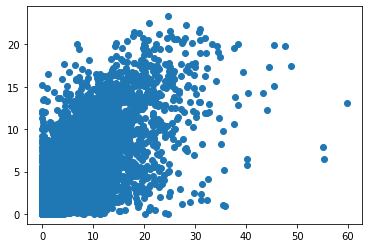

In [65]:
plt.scatter(y_test,np.array(y_predicted_svm_test))

In [66]:
ytrain.describe()

,Ground_truth
count,161879.000000
mean,1.942551
std,4.186512
min,0.000000
25%,0.000000
50%,0.200000
75%,1.600000
max,93.500000


In [67]:
train.columns

Index(['number_sta', 'ff_mean', 'ff_min', 'ff_max', 'ff_std', 'ff_median',
       'ff_sum', 'ff_count', 'ff_percentile_10', 'ff_percentile_25',
       'ff_percentile_80', 'ff_percentile_95', 't_mean', 't_min', 't_max',
       't_std', 't_median', 't_sum', 't_count', 't_percentile_10',
       't_percentile_25', 't_percentile_80', 't_percentile_95', 'td_mean',
       'td_min', 'td_max', 'td_std', 'td_median', 'td_sum', 'td_count',
       'td_percentile_10', 'td_percentile_25', 'td_percentile_80',
       'td_percentile_95', 'hu_mean', 'hu_min', 'hu_max', 'hu_std',
       'hu_median', 'hu_sum', 'hu_count', 'hu_percentile_10',
       'hu_percentile_25', 'hu_percentile_80', 'hu_percentile_95', 'dd_mean',
       'dd_min', 'dd_max', 'dd_std', 'dd_median', 'dd_sum', 'dd_count',
       'dd_percentile_10', 'dd_percentile_25', 'dd_percentile_80',
       'dd_percentile_95', 'Prediction', 'day_index', 'Id', 'lat', 'lon',
       'height_sta', 'month', 'day', 'Forecasted'],
      dtype='object')

In [119]:
import joblib

In [121]:
filename = 'regr_svm_na.sav'
joblib.dump(regr_svm_na, filename)
filename = "regr_svm.sav"
joblib.dump(regr_svm,filename)

['regr_svm.sav']